In [1]:
from package import *

import requests
from pprint import pprint
from functools import partial
import pandas
import matplotlib.pyplot as plt
import os
import sys

github_folder = os.path.join(os.getenv('USERPROFILE'), 'Documents', 'Github', 'python-youtube-api')
sys.path.append(github_folder)

pprint = partial(pprint, width = 200)

#youtube = YouTubeDatabase(github.youtube_api_key, 'youtube_database')

test_video = "836Lv_swaCk"
roosterteeth = 'UCzH3iADRIq1IJlIXjfNgTpA'
vs_playlist = "PLTur7oukosPH7Kvex9-rUiZgVIVGt6C--"
youtube = YouTube(github.youtube_api_key)
print("Finished!")


Finished!


In [2]:
funhaus_id = "UCboMX_UNgaPBsUOIgasn3-Q"
vs = youtube.getPlaylistItems(vs_playlist)
fname = r"C:\Users\Progi\Documents\GitHub\YoutubeAPI\vs_playlist.yaml"

vs.toFile(fname)
pprint(vs)

In [ ]:
def CallApi(endpoint, request_key = None):
	youtube_key = github.youtube_api_key

	apis = {
		'videos.list':        'https://www.googleapis.com/youtube/v3/videos',
		'search.list':        'https://www.googleapis.com/youtube/v3/search',
		'channels.list':      'https://www.googleapis.com/youtube/v3/channels',
		'playlists.list':     'https://www.googleapis.com/youtube/v3/playlists',
		'playlistItems.list': 'https://www.googleapis.com/youtube/v3/playlistItems',
		'activities':         'https://www.googleapis.com/youtube/v3/activities',
		'subscriptions.list': 'https://www.googleapis.com/youtube/v3/subscriptions'
	}

	default_keys = {
		'channels':      'UCjdQaSJCYS4o2eG93MvIwqg',
		'playlists':     'PL2j9QLLdcYBF7j98MxC05Z_gjKckmz462',
		'playlistItems': 'PL2j9QLLdcYBF7j98MxC05Z_gjKckmz462',
		'videos':        '836Lv_swaCk',
		'subscriptions': 'UC_x5XG1OV2P6uZZ5FSM9Ttw'
	}

	if request_key is None:
		request_key = default_keys[endpoint]

	default_parameters = {
		'channels':      {
			'id':   request_key,
			'part': "snippet,statistics,topicDetails"
		},

		'playlists':     {
			'id':         request_key,
			'maxResults': '50',
			'part':       "snippet,contentDetails"
		},

		'playlistItems': {
			'playlistId': request_key,
			'maxResults': '5',
			'part':       'snippet'
		},
		'subscriptions':   {
			'channelId': request_key,
			'part':      'id,snippet,contentDetails,subscriberSnippet'
		},

		'videos':        {
			'id':   request_key,
			'part': 'snippet,contentDetails,statistics,topicDetails'
		}
	}
	parameters = default_parameters[endpoint]
	parameters['key'] = youtube_key

	url = apis[endpoint + '.list']
	response = requests.get(url, parameters)

	response = response.json()
	return response
my_channel = 'UCZLiV1nlp-U32u0QP7Ng2Ow'
result = CallApi('videos')




Finished


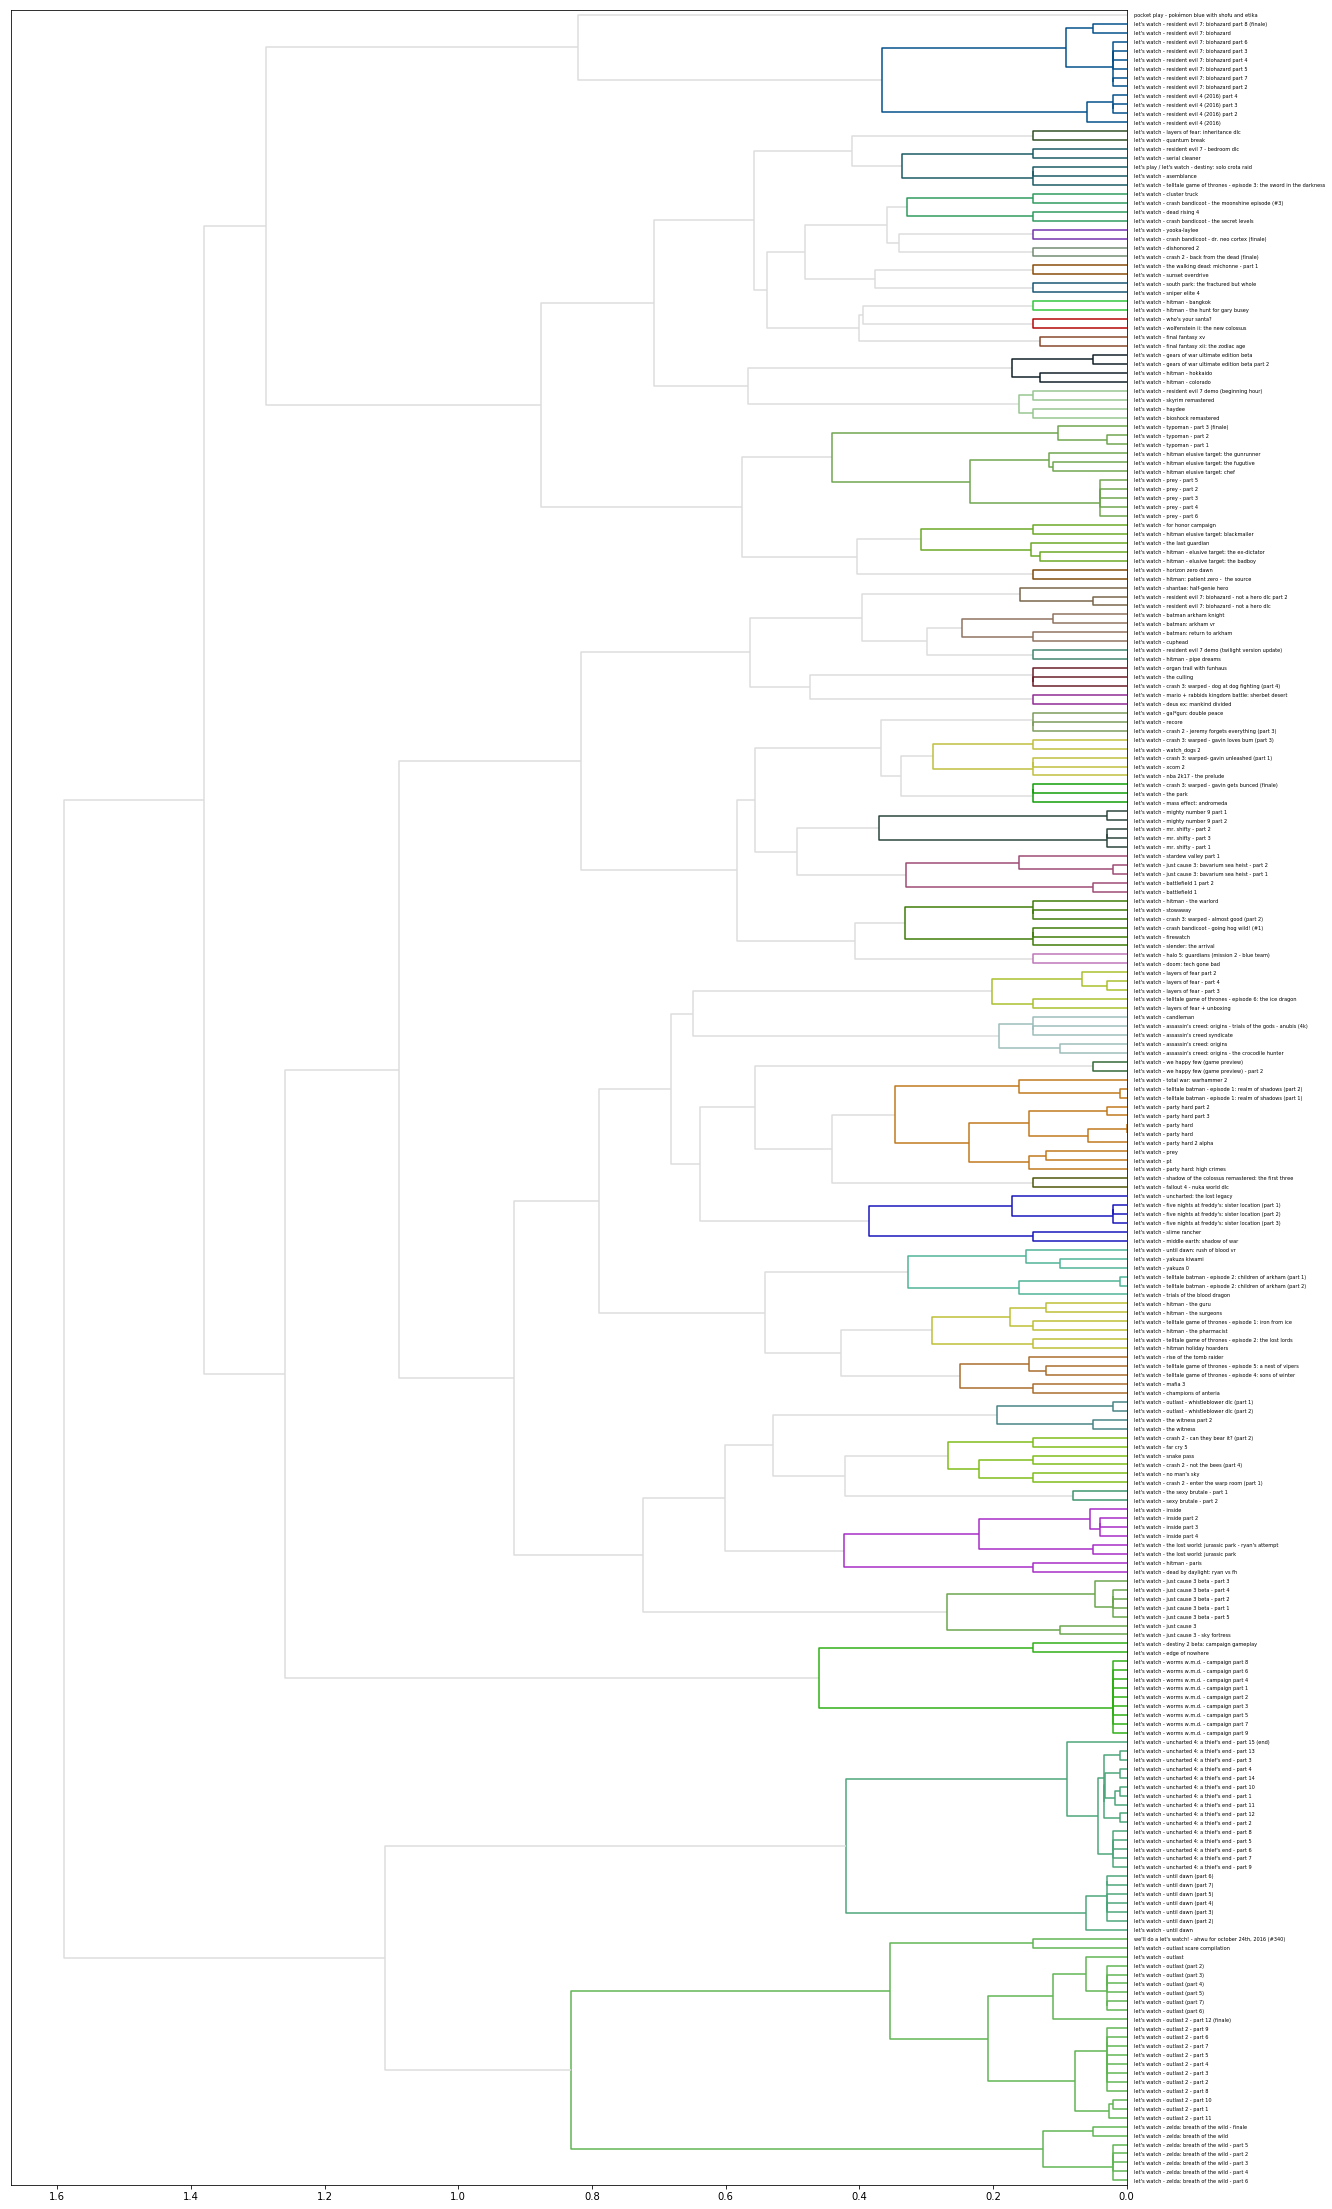

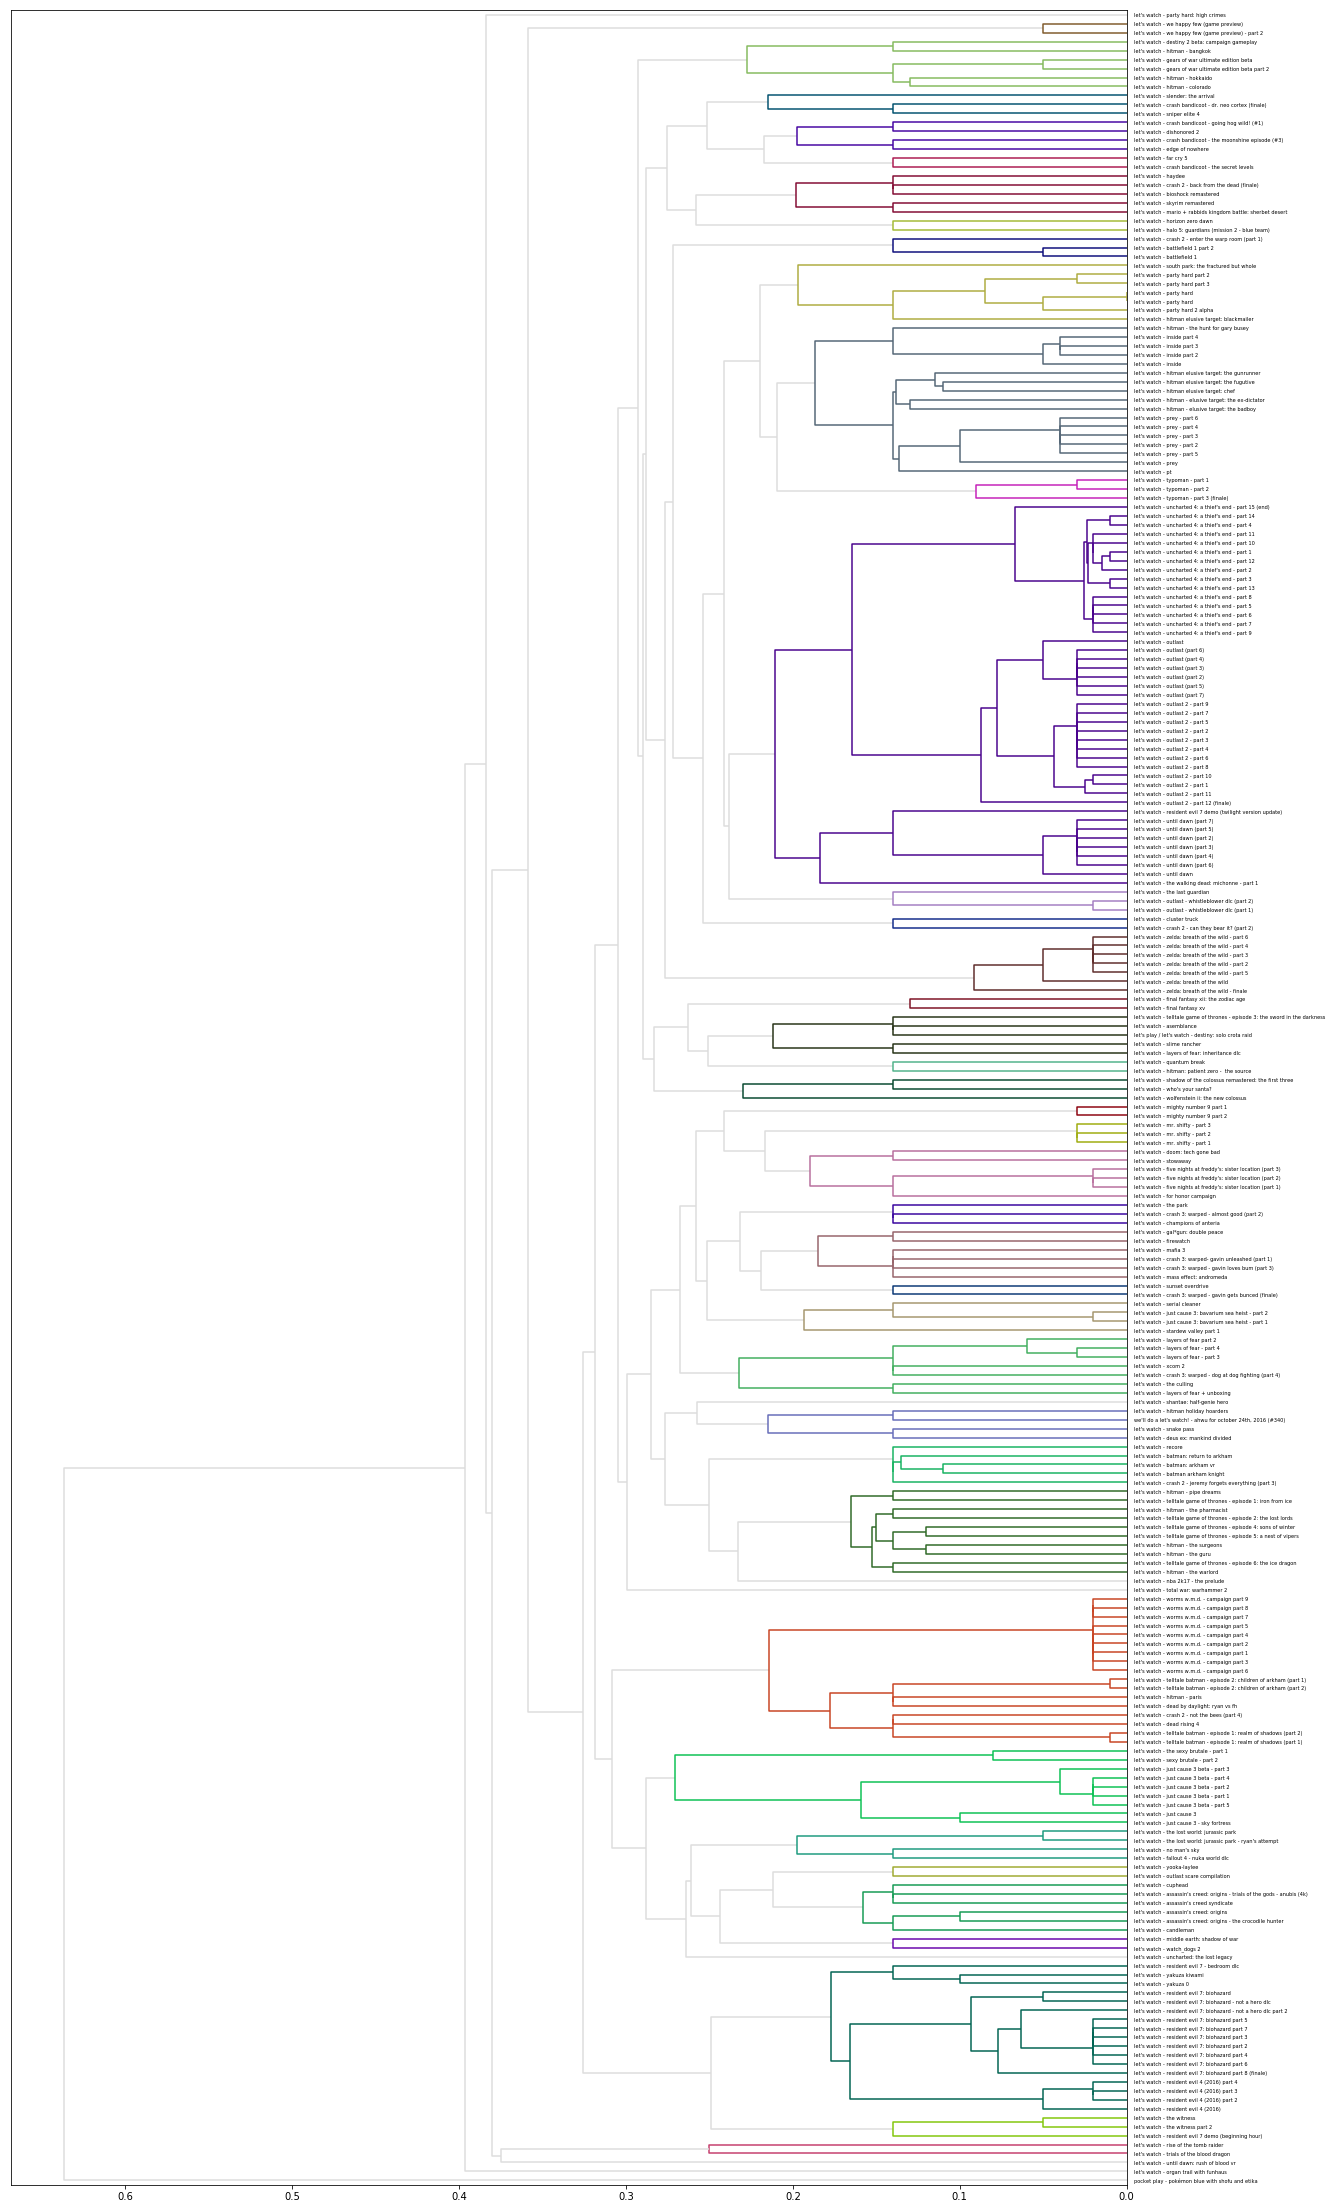

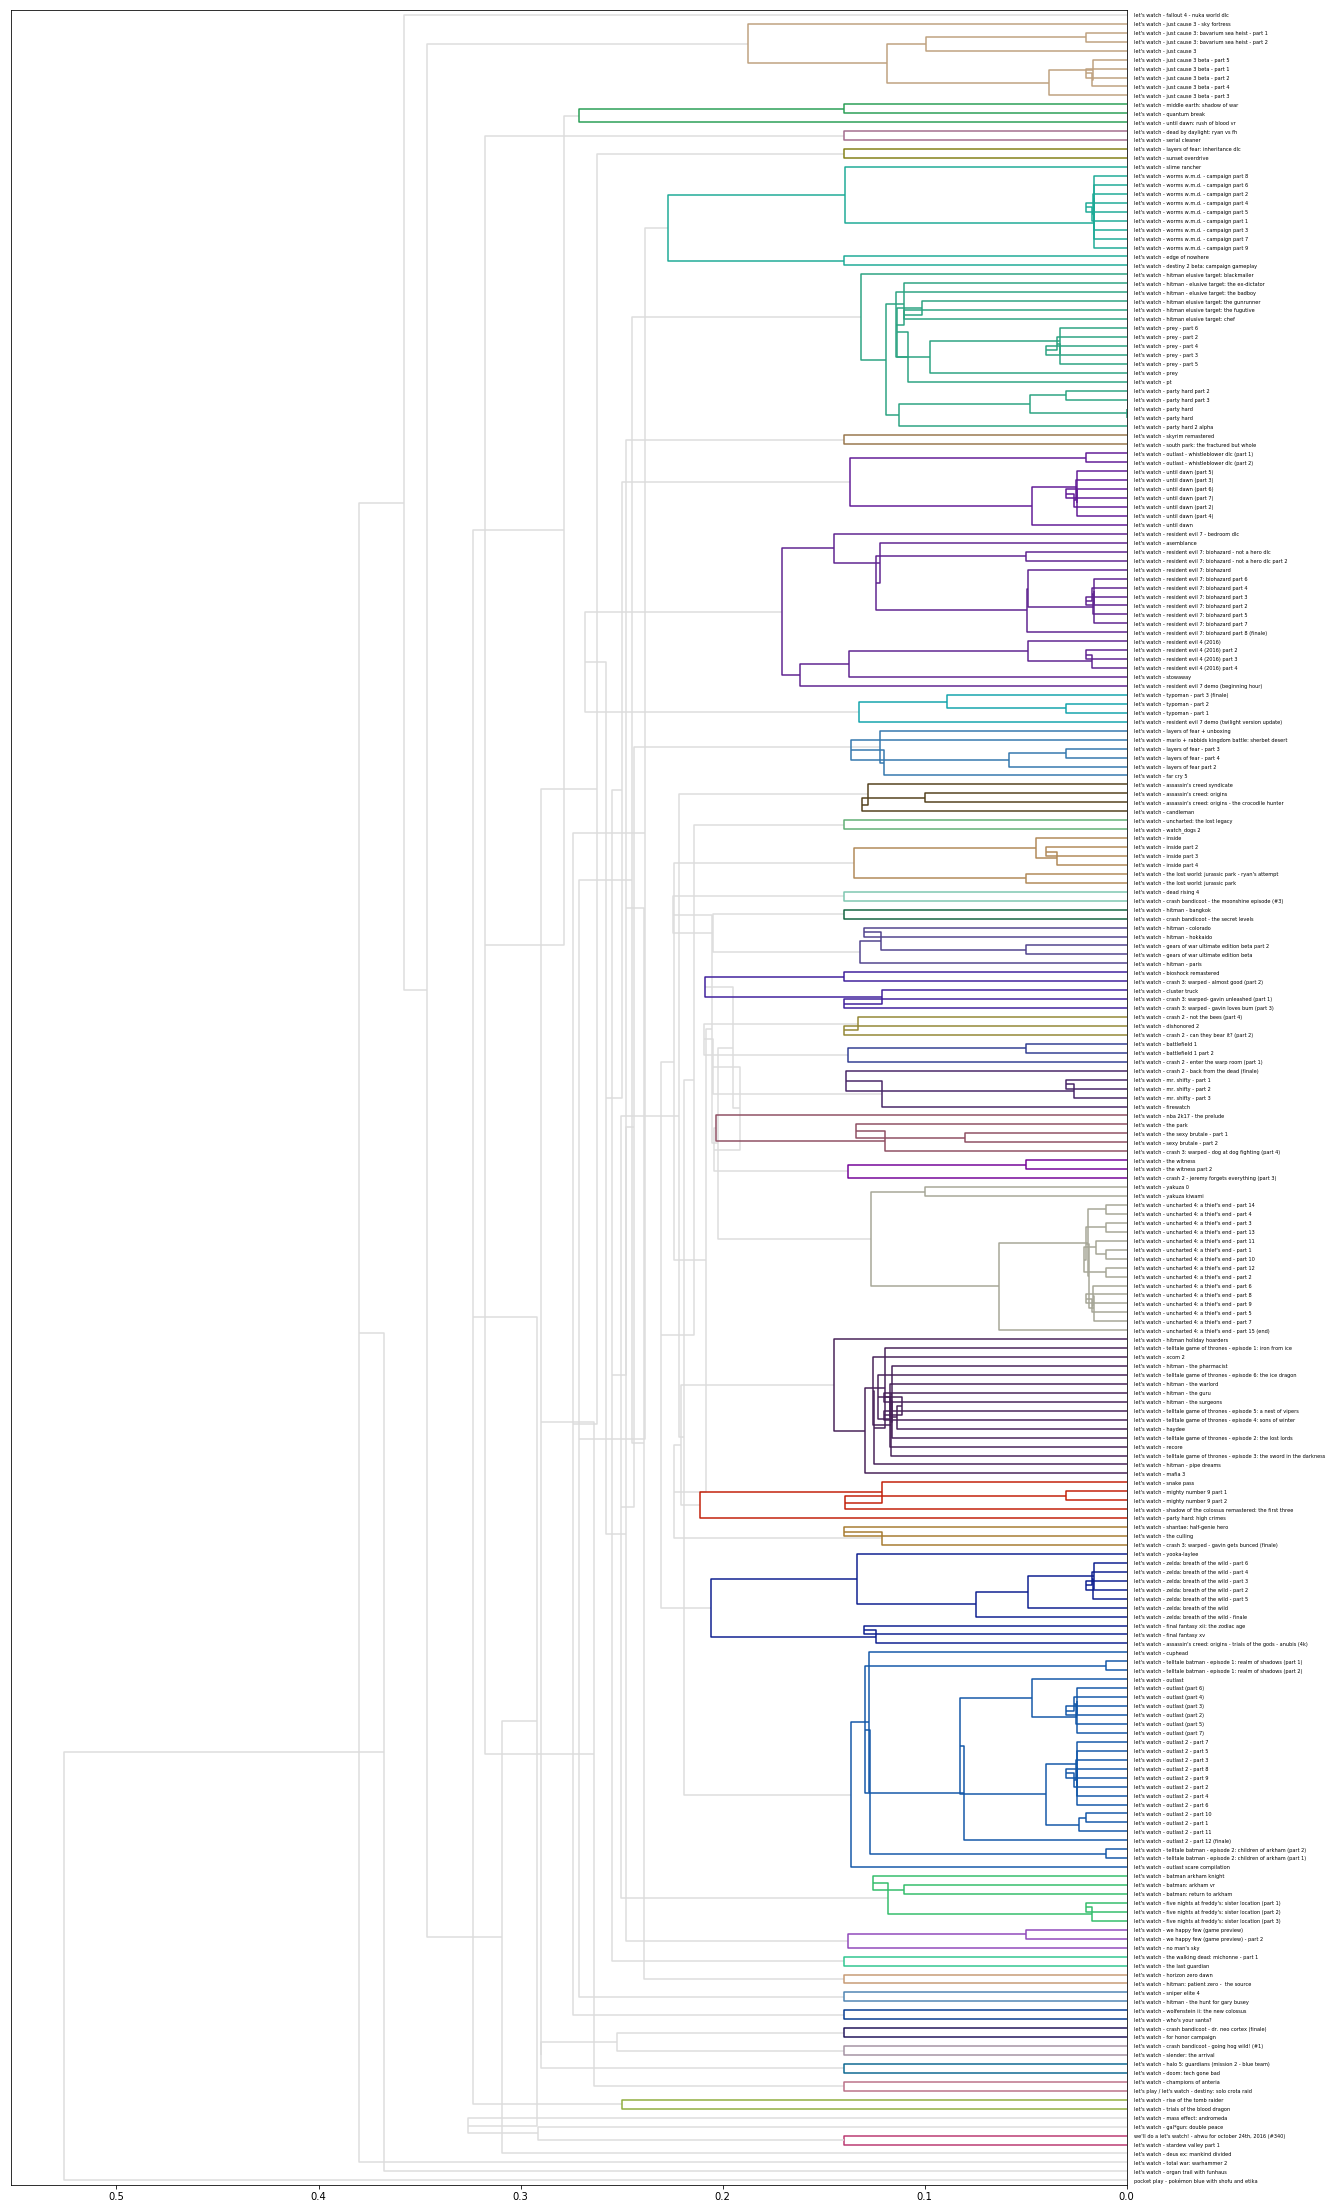

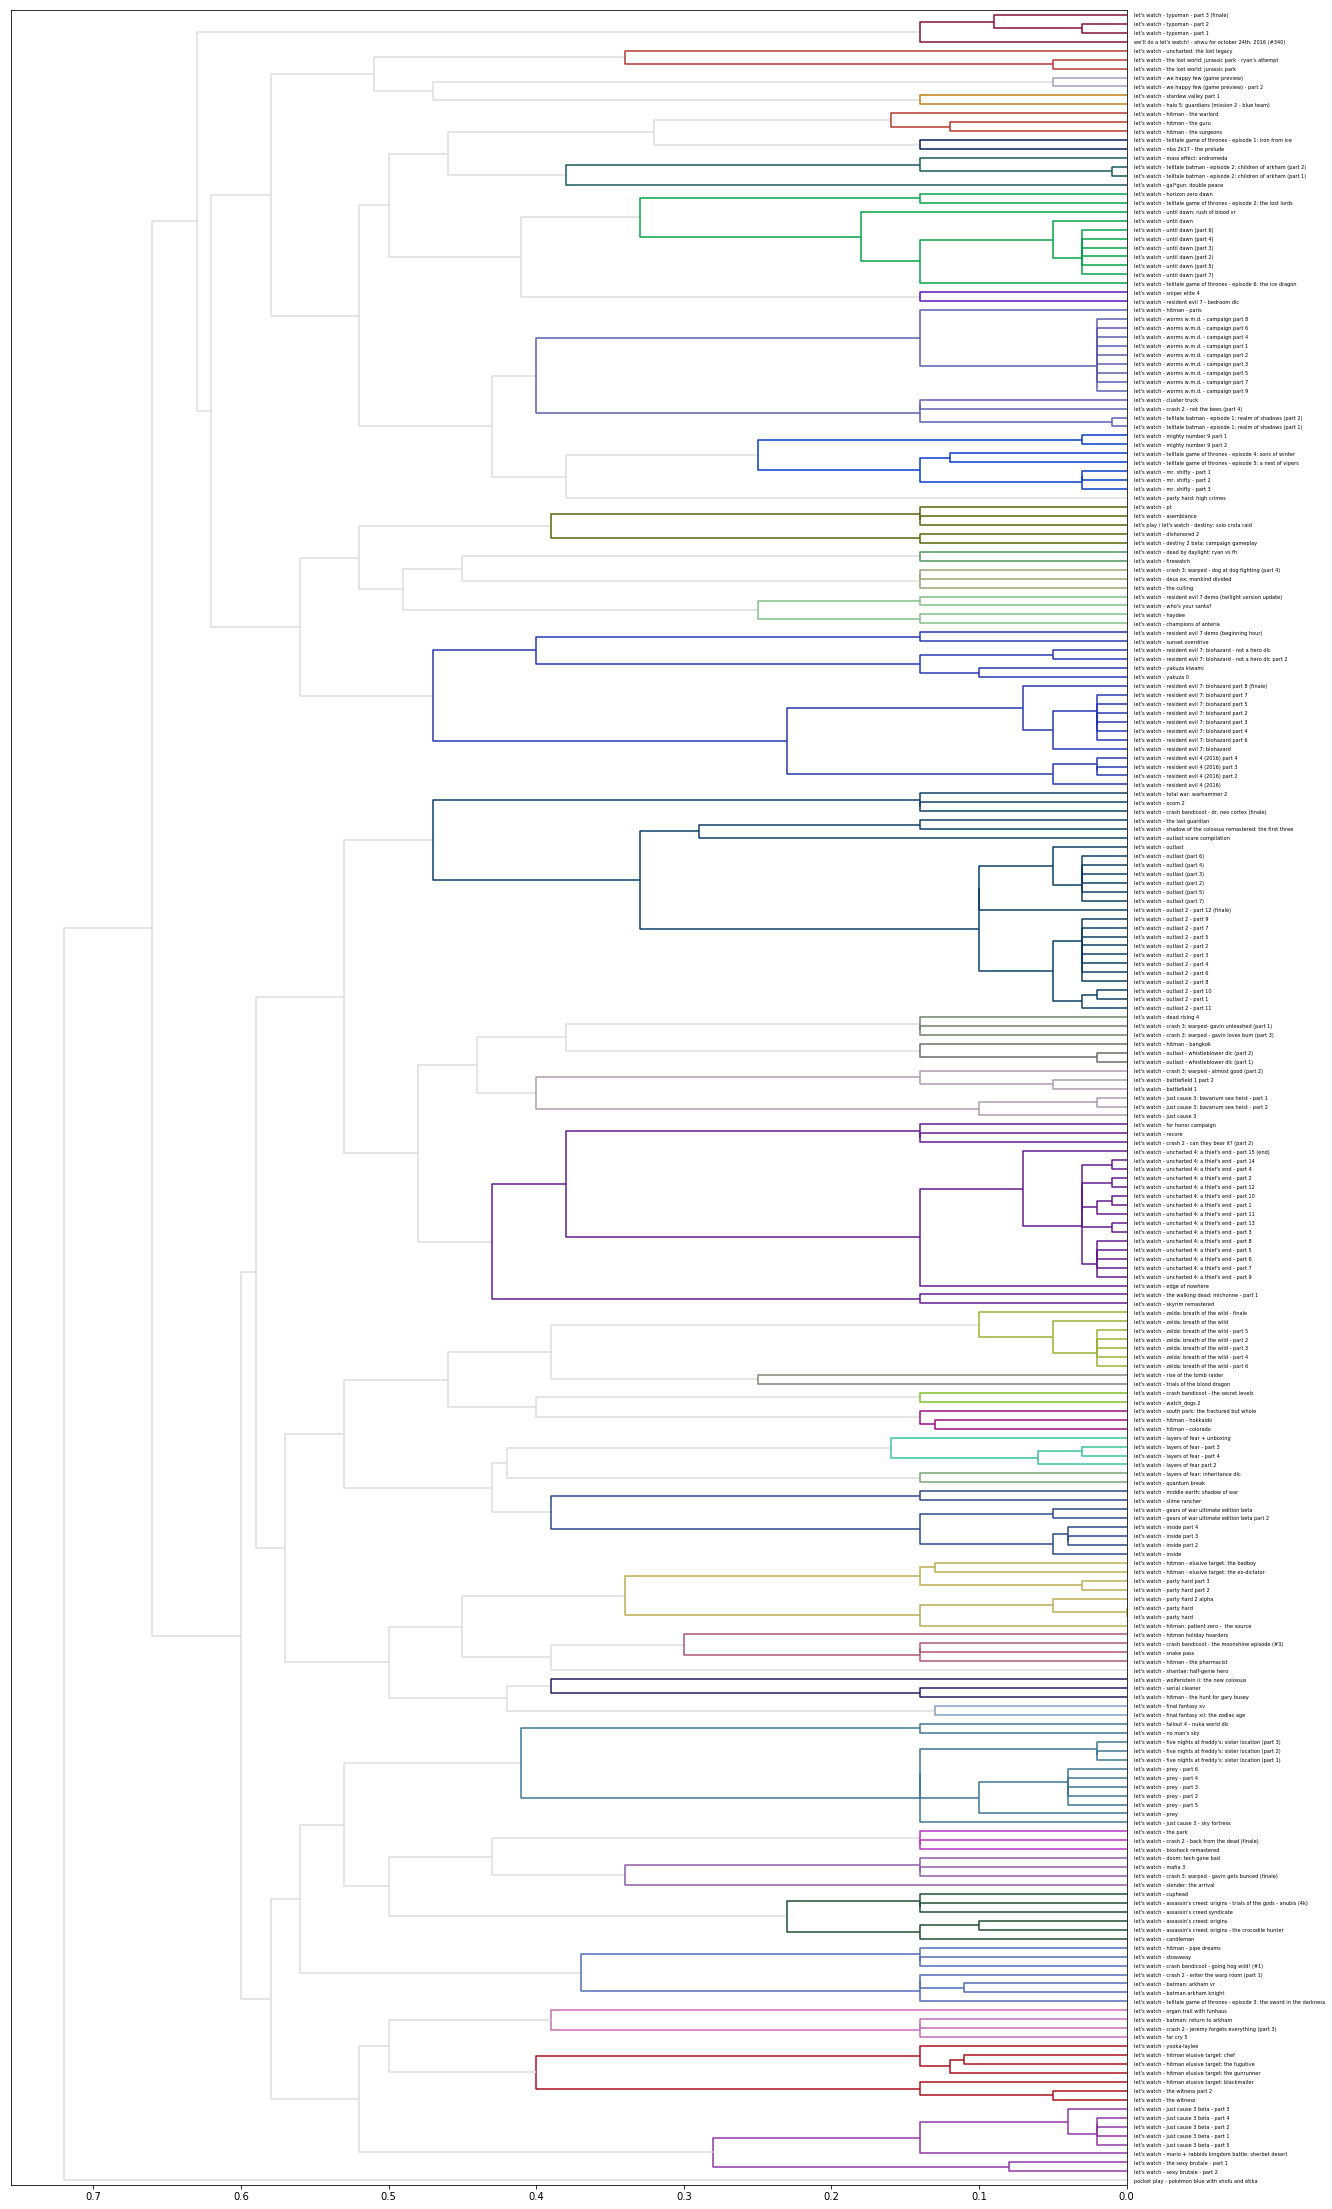

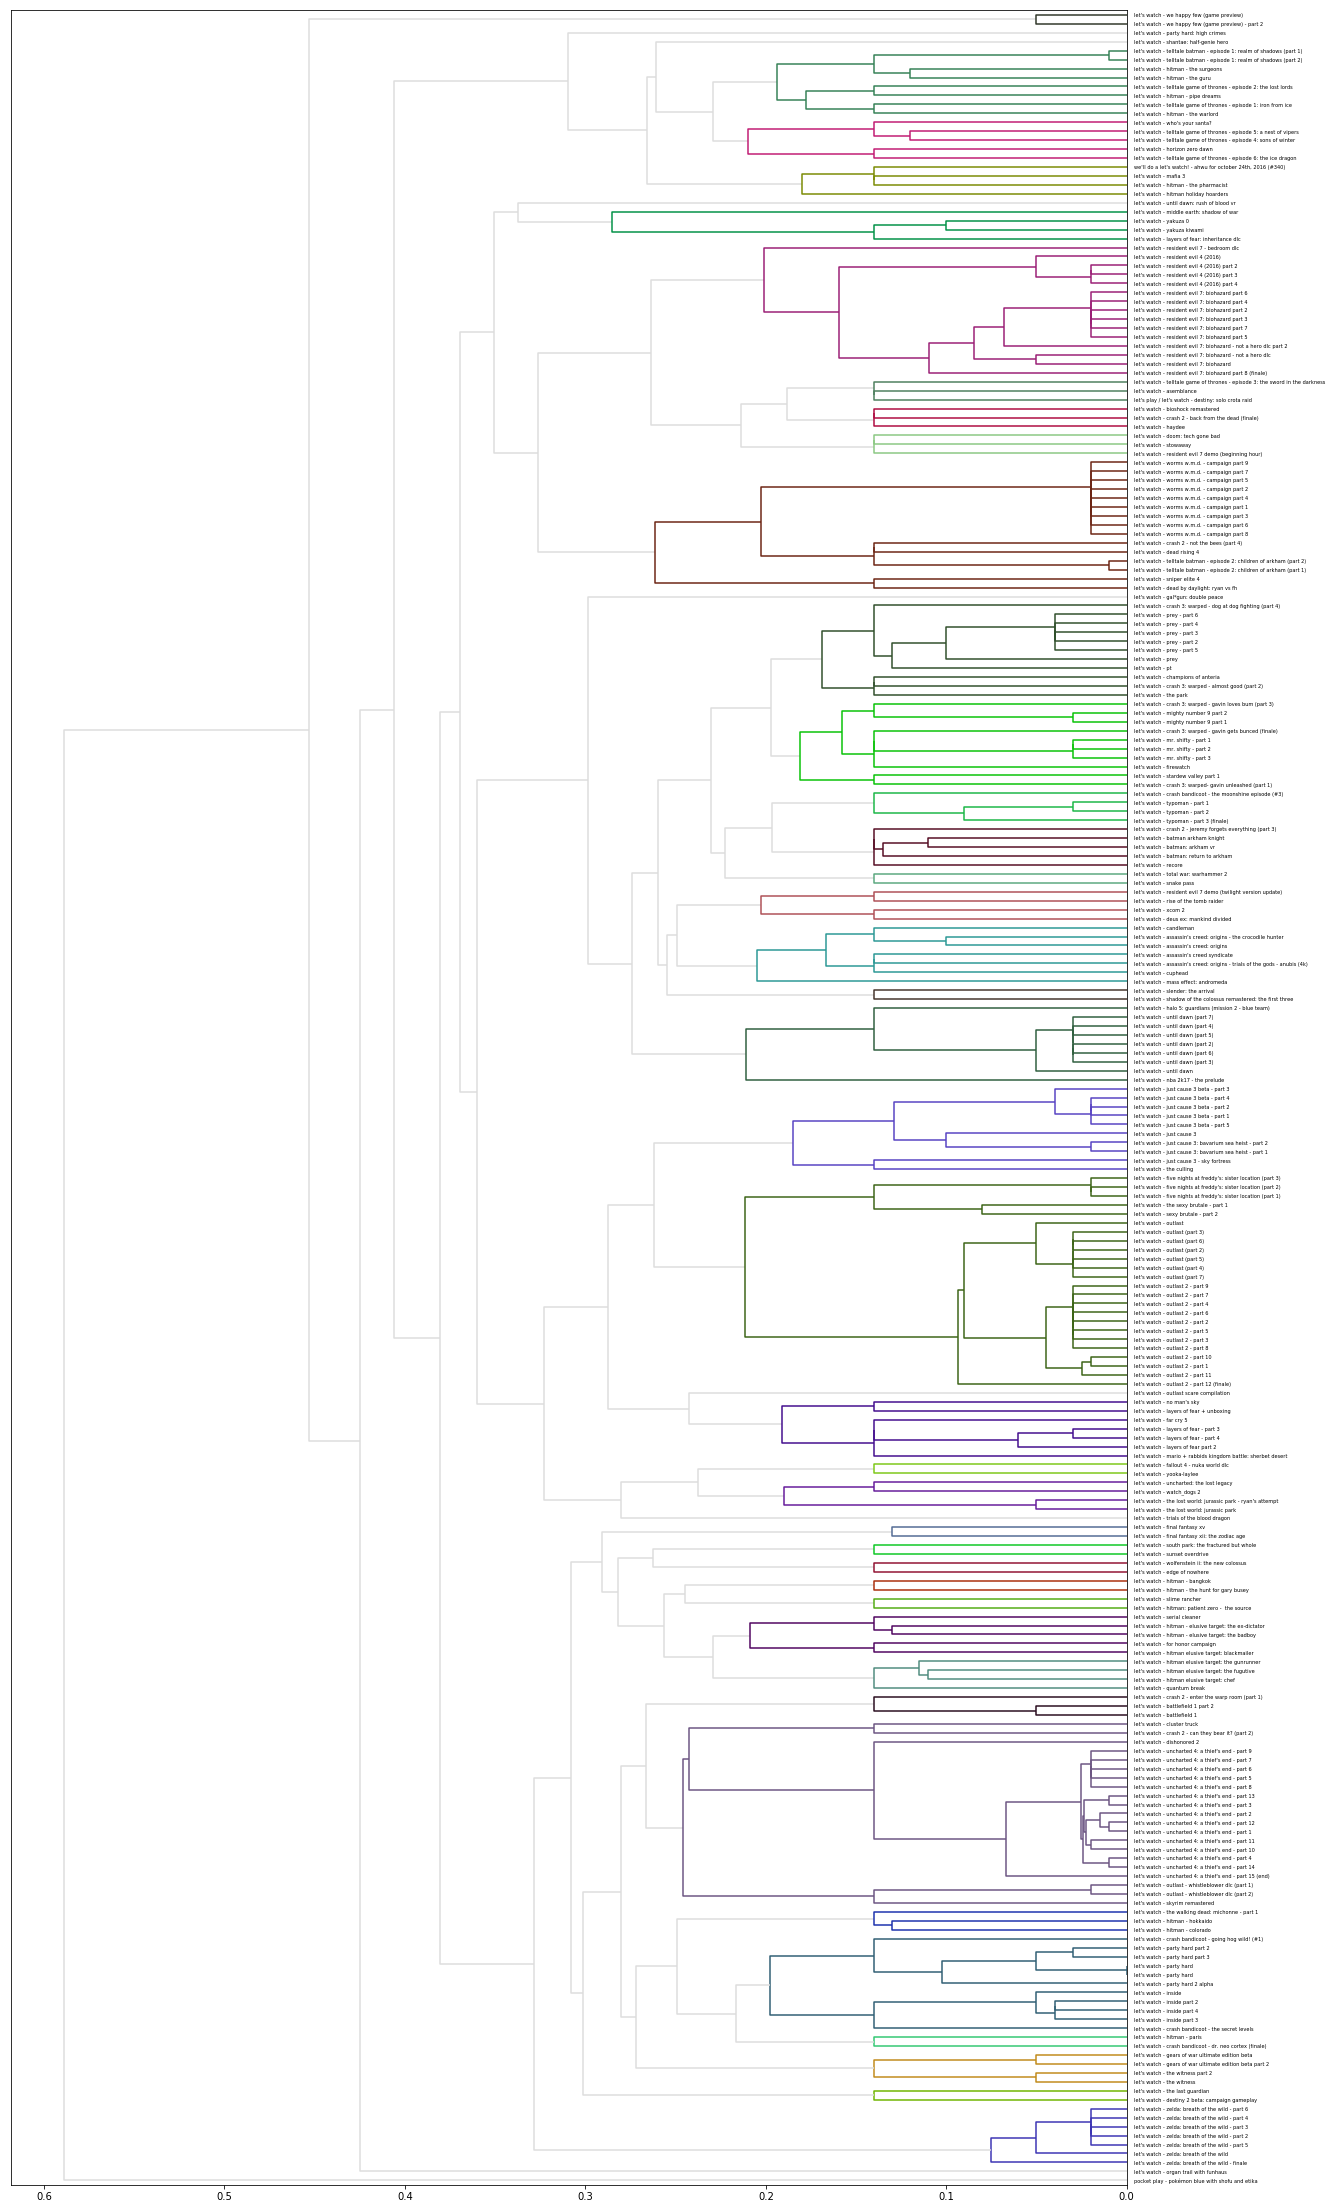

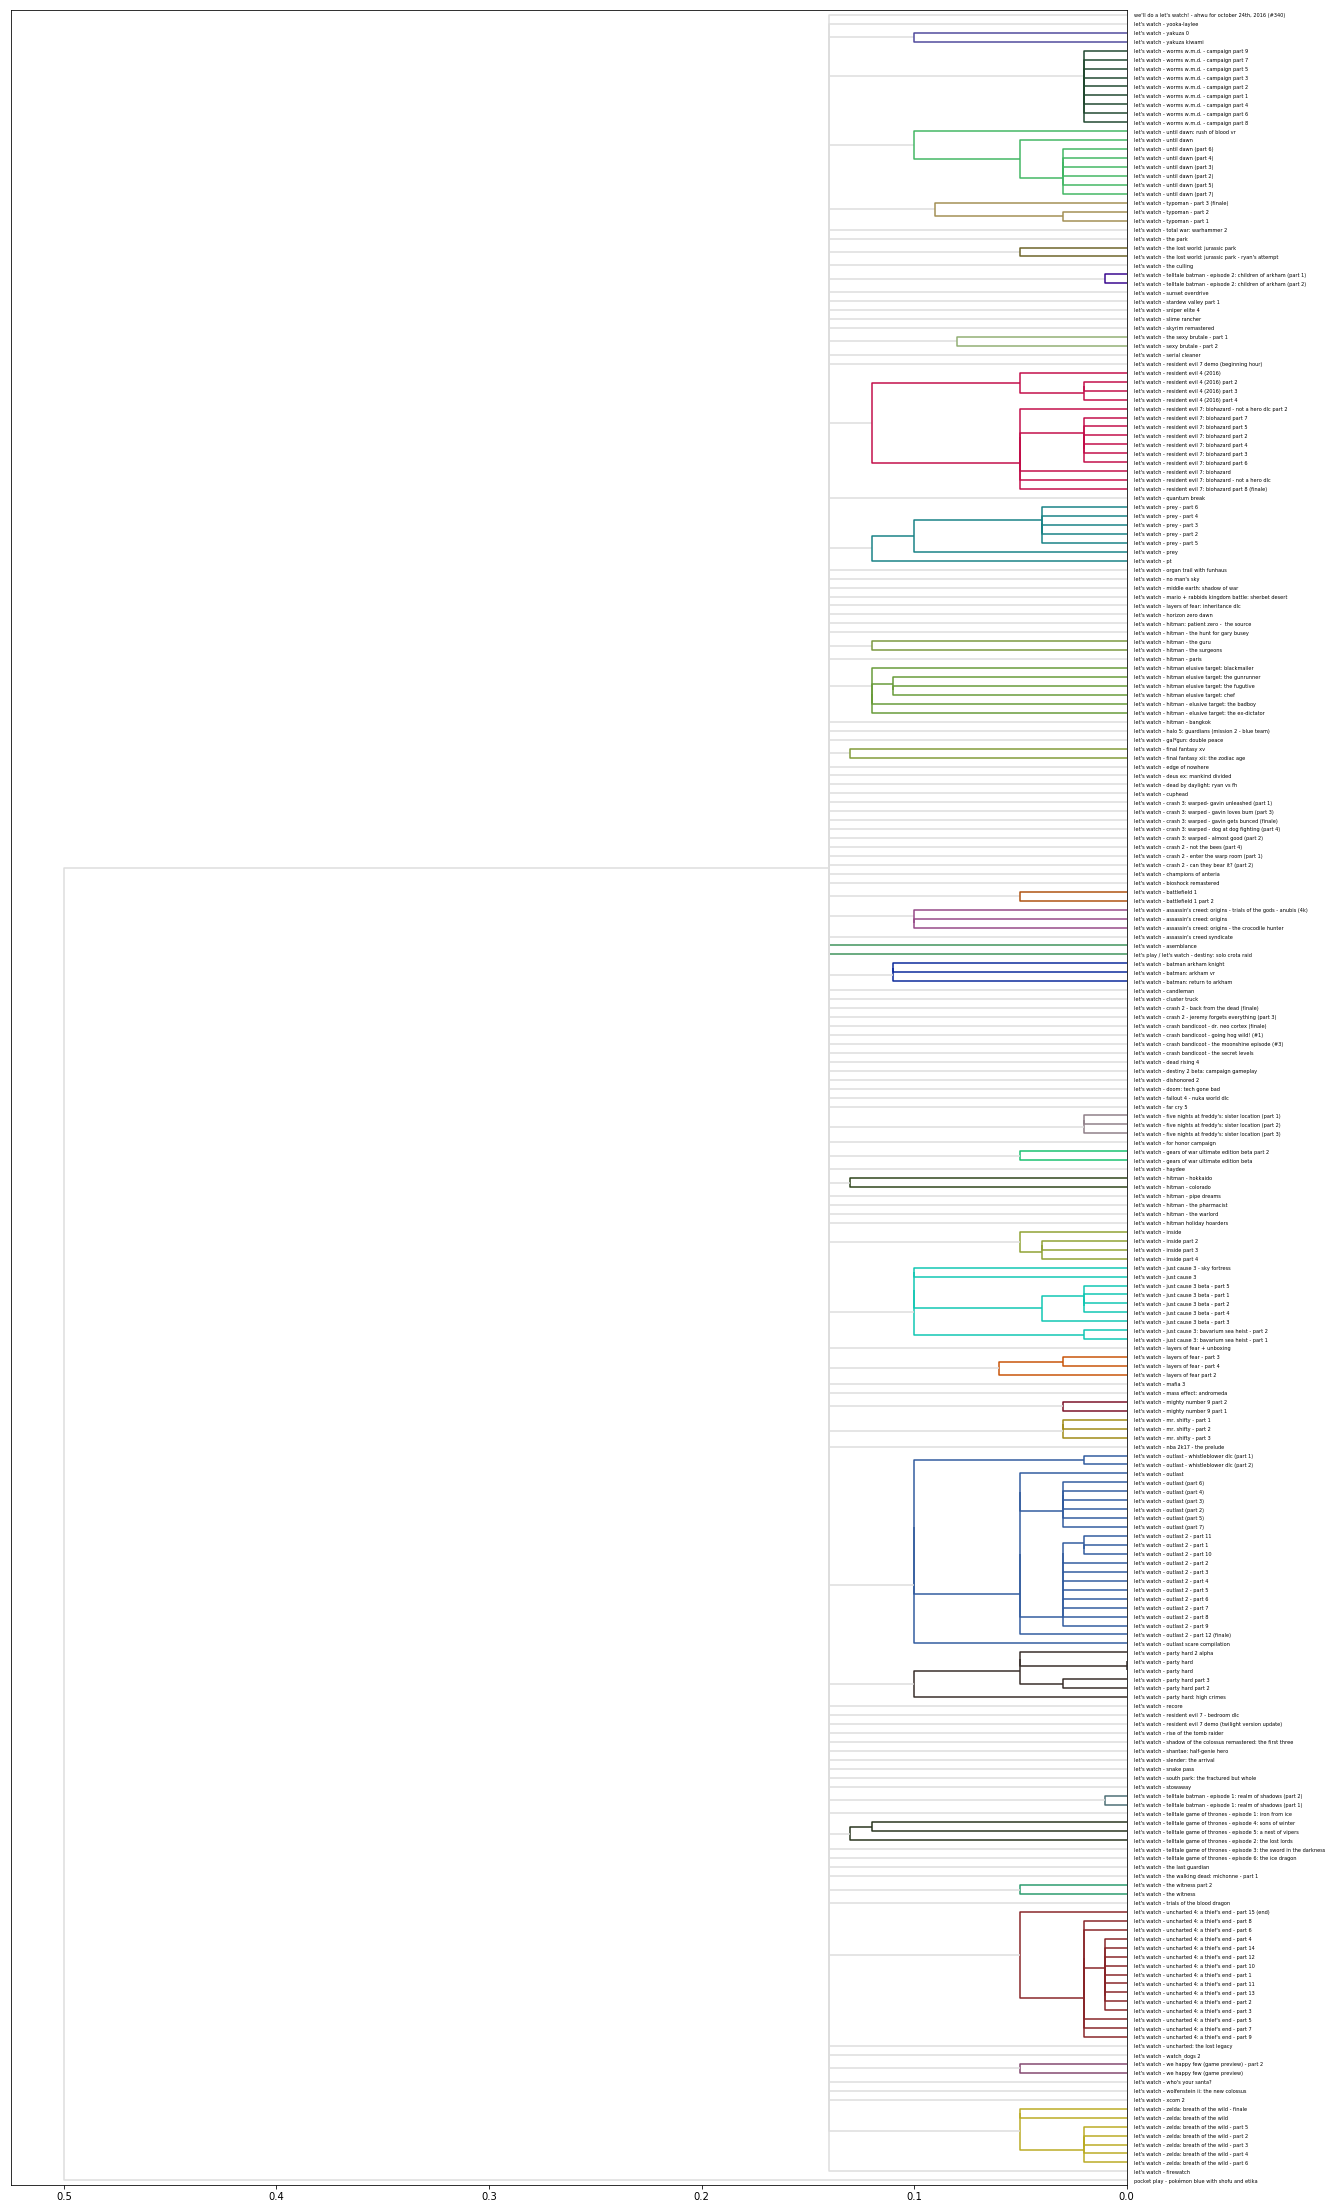

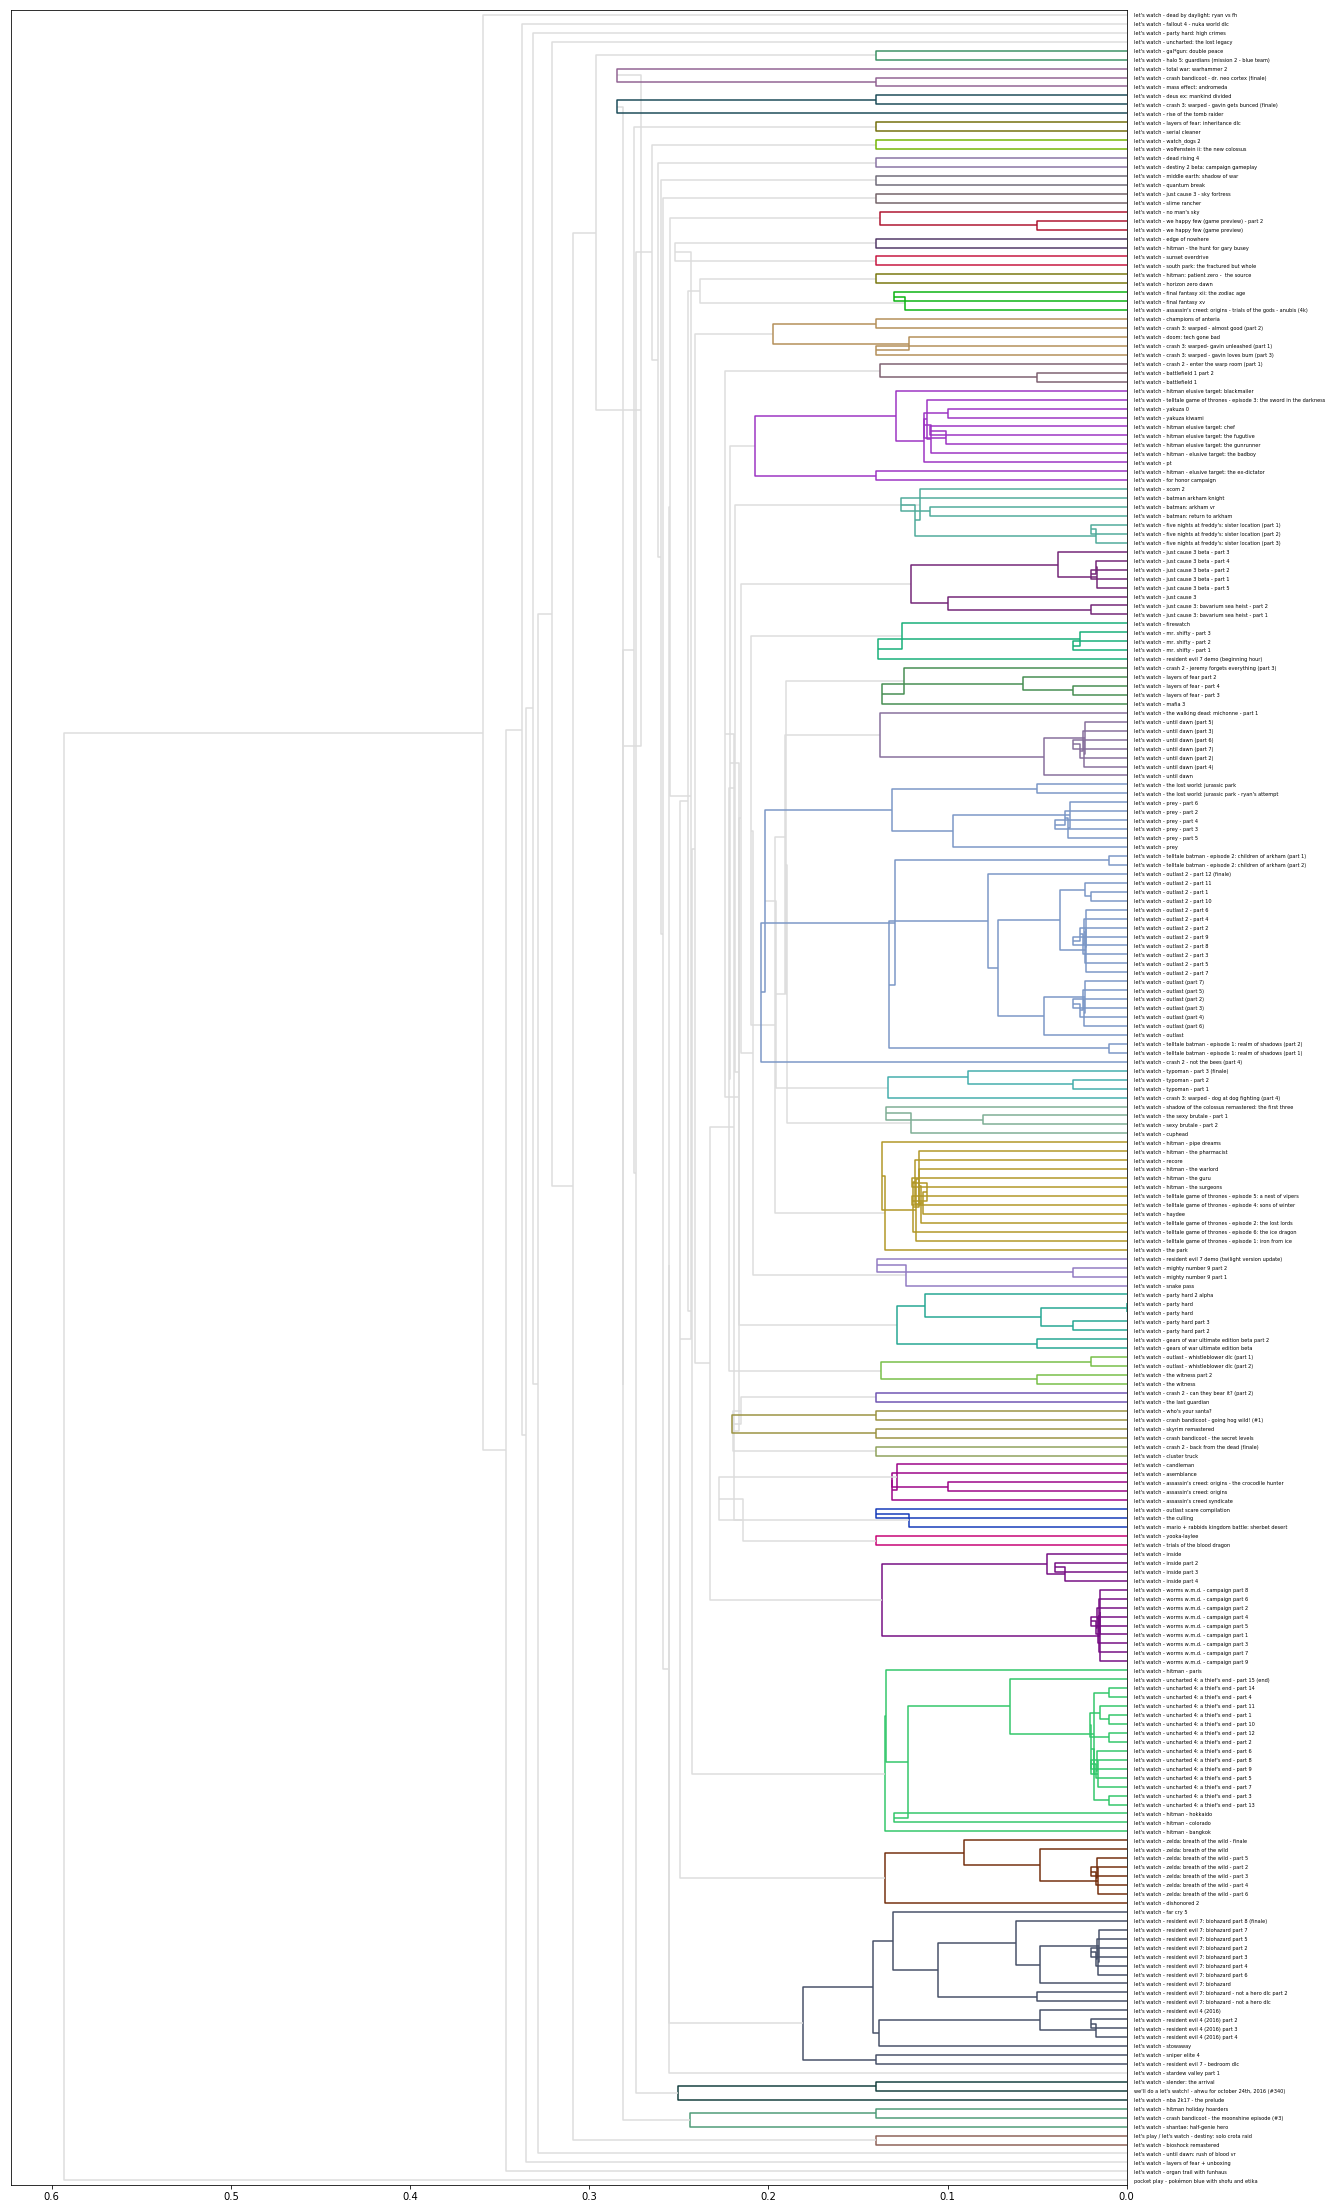

In [47]:
import itertools
from functools import reduce
from fuzzywuzzy import fuzz
import numpy as np
import scipy
import scipy.spatial
import scipy.cluster
import scipy.stats
import random
%matplotlib inline
def getcommonletters(strlist):
    return ''.join([x[0] for x in zip(*strlist) if reduce(lambda a,b:(a == b) and a or None,x)])
    

def findcommonstart(strlist):
    strlist = strlist[:]
    prev = None
    while True:
        common = getcommonletters(strlist)
        if common == prev:
            break
        strlist.append(common)
        prev = common

    return getcommonletters(strlist)

class BuildTree:
    """
        Parameters
        ----------
            method: {'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'}
    """
    def __init__(self, array, method = 'single'):
        self.method = method
        self.color_map = dict()
        self.array = sorted([i.lower() for i in array])
        
        self.ratio_map, self.distance_map = self._generateDistanceMap(self.array)
        
        lev_distance = [[self.getDistance(i, j) for j in lets_watch_titles] for i in lets_watch_titles]
        lev_distance = np.asarray(lev_distance)

        upper_triangle = scipy.spatial.distance.squareform(lev_distance)
        
        self.linkage_clusters = scipy.cluster.hierarchy.linkage(
            upper_triangle, 
            method = self.method,
            optimal_ordering = True
        )
        
        self.root = scipy.cluster.hierarchy.to_tree(self.linkage_clusters)
        
    def getSubClusters(self, cluster):
        children = [cluster.id]
        if not cluster.is_leaf():
            children += self.getSubClusters(cluster.get_left())
            children += self.getSubClusters(cluster.get_right())
        return children
        
    @property
    def Z(self):
        return self.linkage_clusters
    def _calculateRatio(self, i, j, toratio = False):
        a, b = sorted([i, j])
        #ratio = fuzz.token_sort_ratio(a, b)
        ratio = fuzz.WRatio(a, b)
        return ratio
    def _generateDistanceMap(self, array):
        ratio_map = dict()
        todistance = lambda s: (100-s)/100
        for i, j in itertools.product(array, repeat = 2):
            ratio = self._calculateRatio(i, j)
            ratio_map[(i, j)] = ratio
        distance_map = {key: todistance(value) for key, value in ratio_map.items()}
        return ratio_map, distance_map
    def getDistance(self, i, j):
        return self.distance_map[(i, j)]
    def getRatio(self, i, j):
        return self.ratio_map[(i, j)]
    def generateRandomColor(self):
        _min = 0
        _max = 200
        r = random.randint(_min, _max)
        g = random.randint(_min, _max)
        b = random.randint(_min, _max)
        c = "#{:>02X}{:>02X}{:>02X}".format(r,g,b)
        return c
    def _addClusterColor(self, cluster):
        color = self.generateRandomColor()
        cluster_children = self.getSubClusters(cluster)

        for i in cluster_children:
            self.color_map[i] = color
        
    def analyzeHierarchy(self, tree = None, score_cutoff = 85, ratio_cutoff = 80, verbose = True):
        #minimum_distance = (100-score_cutoff) / 100

        
        minimum_distance = score_cutoff
        if tree is None:
            tree = self.root
        tree_metrics = self.getClusterMetrics(tree)
        
        score = tree_metrics['clusterScore']
        common_substring = findcommonstart(tree_metrics['clusterLeafs'])
        
        is_similar = score >= score_cutoff
        is_substring = all([(len(common_substring)/ len(i)) >=.67 for i in tree_metrics['clusterLeafs']])
        is_substring = False
        is_group = is_similar or is_substring # and min(tree_metrics['clusterRatios']) >= ratio_cutoff
        if is_group:
            self._addClusterColor(tree)
            if False:
                print("{} ({:.2f})".format(tree_metrics['clusterId'], score))
                for leaf in tree_metrics['clusterLeafs']:
                    #_leaf_comparison = [self.getRatio(leaf, i) for i in tree_metrics['clusterLeafs']]
                    #_comparison = '|'.join([str(i) for i in _leaf_comparison])
                    _comparison = ''
                    print("\t{} ({})".format(leaf, _comparison))
        else:
            self.color_map[tree.id] = '#DDDDDD'
            left = tree.get_left() 
            right = tree.get_right()
            if left and right and False:
                print("{} ({}, {})|({}, {})".format(tree.id, left.id, left.count, right.id, right.count))
            if left is not None:
                self.analyzeHierarchy(left)
            if right is not None:
                self.analyzeHierarchy(right)
                

    def _calculateSimilarityScore(self, strings):
        ratios = list()
        for i, j in itertools.product(strings, repeat = 2):
            ratios.append(self.getRatio(i, j))
        # ratios = set(ratios)
        score = sum(ratios) / len(ratios)
        return score, ratios
    def _getLeafs(self, indicies):
        return [self.array[i] for i in indicies if i < len(self.array)]
    def getClusterMetrics(self, cluster):
        children = cluster.pre_order(lambda s: s.id)
        leafs = self._getLeafs(children)
        similarity_score, ratios = self._calculateSimilarityScore(leafs)
        
        metrics = {
            'clusterId': cluster.id,
            'clusterName': findcommonstart(leafs),
            'clusterLeafs': leafs,
            'clusterScore': similarity_score,
            'clusterRatios': ratios
        }
        return metrics

        

    def savefig(self):
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize = (20, 40))
        scipy.cluster.hierarchy.dendrogram(
            test.Z, 
            orientation = 'left', 
            ax = ax, 
            labels = self.array, 
            color_threshold = 0.00005,
            link_color_func = lambda s: self.color_map[s]
        )
        fname = "C:\\Users\\Progi\\Documents\\GitHub\\hierarchy.{}.png".format(self.method)
        plt.savefig(fname, dpi = 300)
lets_watch_titles = sorted([i['playlistItemName'].lower().strip() for i in lets_watch.items])

for i in ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']:
    if True:
        test = BuildTree(lets_watch_titles, method = i)

        test.analyzeHierarchy(verbose = False)
        test.savefig()


print("Finished")

In [46]:
crash = [i for i in test.array if 'crash' in i]
pprint(crash)
crash = [i for i in crash if 'crash 3' in i]
ratios = {
    'ratio': [],
    'partialRatio': [],
    'tokenSortRatio': [],
    'tokenSetRatio': [],
    'wRatio': [],
    'qRatio': [],
    'partialTokenSortRatio': [],
    'partialTokenSetRatio': []
}
for i in crash:
    for j in crash:
        a, b = sorted([i, j])

        ratios['ratio'].append(fuzz.ratio(a, b))
        ratios['partialRatio'].append(fuzz.partial_ratio(a, b))
        ratios['tokenSortRatio'].append(fuzz.token_sort_ratio(a, b))
        ratios['tokenSetRatio'].append(fuzz.token_set_ratio(a, b))
        ratios['wRatio'].append(fuzz.WRatio(a, b))
        ratios['qRatio'].append(fuzz.QRatio(a, b))
        ratios['partialTokenSortRatio'].append(fuzz.partial_token_sort_ratio(a, b))
        ratios['partialTokenSetRatio'].append(fuzz.partial_token_set_ratio(a, b))

for k, v in ratios.items():
    print(k)
    print("\tMean: {:.2f} ± {:.4f} (median = {}, nunique = {})".format(
        sum(v) / len(v), np.std(v), np.median(v), len(set(v))))
    
    #print("\t", ','.join([str(i) for i in v]))

["let's watch - crash 2 - back from the dead (finale)",
 "let's watch - crash 2 - can they bear it? (part 2)",
 "let's watch - crash 2 - enter the warp room (part 1)",
 "let's watch - crash 2 - jeremy forgets everything (part 3)",
 "let's watch - crash 2 - not the bees (part 4)",
 "let's watch - crash 3: warped - almost good (part 2)",
 "let's watch - crash 3: warped - dog at dog fighting (part 4)",
 "let's watch - crash 3: warped - gavin gets bunced (finale)",
 "let's watch - crash 3: warped - gavin loves bum (part 3)",
 "let's watch - crash 3: warped- gavin unleashed (part 1)",
 "let's watch - crash bandicoot - dr. neo cortex (finale)",
 "let's watch - crash bandicoot - going hog wild! (#1)",
 "let's watch - crash bandicoot - the moonshine episode (#3)",
 "let's watch - crash bandicoot - the secret levels"]
ratio
	Mean: 82.16 ± 10.0744 (median = 80.0, nunique = 9)
partialRatio
	Mean: 80.88 ± 10.3279 (median = 79.0, nunique = 9)
tokenSortRatio
	Mean: 76.64 ± 12.7715 (median = 74.0, nu

In [34]:
dir(fuzz.utils)

['PY3',
 'StringProcessor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'asciidammit',
 'asciionly',
 'bad_chars',
 'check_empty_string',
 'check_for_none',
 'full_process',
 'functools',
 'intr',
 'make_type_consistent',
 'sys',
 'translation_table',
 'unicode',
 'unicode_literals',
 'validate_string']